<a href="https://colab.research.google.com/github/AngelSylvi/Angeline/blob/main/Oilspill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jcopdl

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-2.3.2-py2.py3-none-any.whl size=38046 sha256=5776281eab6b8f6fa6b75b1c3264eb9f1c4f5e3bd726436b3623c682549df753
  Stored in directory: /root/.cache/pip/wheels/96/ff/b1/d8cd28e2531191e146dc50f92ee777445e68a1b1904476d547
Successfully built jcopdl


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import jcopdl
from torch import nn, optim
from jcopdl.callback import Callback
from sklearn import set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [6]:
bs = 16
crop_size = 128

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale = (0.9, 1.0)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(140),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

!unrar x /content/train.rar # extract the rar file
!unrar x /content/test.rar

train_set = datasets.ImageFolder("/content/train", transform=train_transform) # update path
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=1)

test_set = datasets.ImageFolder("/content/test", transform=test_transform) # update path
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/train.rar

Creating    train                                                     OK
Creating    train/nospill                                             OK
Extracting  train/nospill/10.JPG                                           0%  OK 
Extracting  train/nospill/107236308_280307353186763_643091203316669176_n.jpg       0%  OK 
Extracting  train/nospill/11.JPG                                           0%  OK 
Extracting  train/nospill/119230725_343085617124646_1317333075612491072_n.jpg       1%  OK 
Extracting  train/nospill/12.JPG                                           1%  OK 
Extracting  train/nospill/122098000_130363281814388_668618684501627625_n.jpg       2%  OK 
Extracting  train/nospill/122099916_1055022261618274_1377545081920588883_n.jpg       3%  OK 
Extracting  train/nospill/122101561_2862778267285030_7822122894

In [7]:
feature, target = next (iter(trainloader))
feature.shape

torch.Size([16, 3, 128, 128])

In [8]:
label2cat = train_set.classes
label2cat

['nospill', 'oilspill']

In [13]:
config = set_config({
    "batch_size" : bs,
    "crop_size": crop_size
})

In [14]:
from model import CNN
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
callback = Callback(model, config, outdir="model", early_stop_patience=  10)

In [15]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [20]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)


In [28]:
class Callback:
    def __init__(self):
        # Initialize any necessary attributes here, such as tracking variables for early stopping
        self.best_score = None
        self.patience_counter = 0
        self.early_stop_patience = 10  # Adjust as necessary

    # Log method to handle the four arguments
    def log(self, train_cost, test_cost, train_score, test_score):
        # Log the values as needed
        print(f"Train Cost: {train_cost}, Test Cost: {test_cost}")
        print(f"Train Score: {train_score}, Test Score: {test_score}")

    # Method to save checkpoints
    def save_checkpoint(self):
        print("Checkpoint saved.")

    # Method to plot costs over time (mock implementation)
    def cost_runtime_plotting(self):
        print("Cost plotting...")

    # Method to plot scores over time (mock implementation)
    def score_runtime_plotting(self):
        print("Score plotting...")

    # Early stopping logic
    def early_stopping(self, model, monitor="test_score"):
        # Example logic for early stopping based on test score
        if self.best_score is None or monitor > self.best_score:
            self.best_score = monitor
            self.patience_counter = 0  # Reset patience
            # Optionally save the best model checkpoint here
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.early_stop_patience:
                print("Early stopping triggered.")
                return True
        return False

    # Plotting method for costs after training
    def plot_cost(self):
        print("Final cost plot.")

    # Plotting method for scores after training
    def plot_score(self):
        print("Final score plot.")


# Assuming loop_fn, train_set, test_set, trainloader, testloader, model, criterion, optimizer, and device are defined elsewhere

# Set a maximum number of epochs for training
max_epochs = 10

# Initialize the callback object
callback = Callback()

# Initialize epoch counter
epoch = 0

while epoch < max_epochs:
    # Perform training for one epoch
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)

    # Perform validation/testing without gradient calculation
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging with four arguments (train_cost, test_cost, train_score, test_score)
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping (breaks the loop if early stopping condition is met)
    if callback.early_stopping(model, monitor=test_score):  # Monitoring based on test score
        callback.plot_cost()
        callback.plot_score()
        break

    # Increment the epoch counter
    epoch += 1

# If the loop exits normally after max_epochs or early stopping
print("Training completed.")


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

Train Cost: 0.2059223991511437, Test Cost: 0.6306753754615784
Train Score: 0.9137055837563451, Test Score: 0.7551020408163265
Checkpoint saved.
Cost plotting...
Score plotting...


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

Train Cost: 0.17815439648888437, Test Cost: 0.6551544666290283
Train Score: 0.9390862944162437, Test Score: 0.7755102040816326
Checkpoint saved.
Cost plotting...
Score plotting...


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

Train Cost: 0.2062572529775842, Test Cost: 0.6656379103660583
Train Score: 0.8984771573604061, Test Score: 0.7551020408163265
Checkpoint saved.
Cost plotting...
Score plotting...


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

Train Cost: 0.1940084813815083, Test Cost: 0.6735806465148926
Train Score: 0.934010152284264, Test Score: 0.7551020408163265
Checkpoint saved.
Cost plotting...
Score plotting...


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

Train Cost: 0.1892051908570498, Test Cost: 0.6759169697761536
Train Score: 0.9086294416243654, Test Score: 0.7551020408163265
Checkpoint saved.
Cost plotting...
Score plotting...


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

Train Cost: 0.16082217714508174, Test Cost: 0.6932302713394165
Train Score: 0.934010152284264, Test Score: 0.7551020408163265
Checkpoint saved.
Cost plotting...
Score plotting...


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

Train Cost: 0.1844941990327109, Test Cost: 0.6681714653968811
Train Score: 0.934010152284264, Test Score: 0.7551020408163265
Checkpoint saved.
Cost plotting...
Score plotting...


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

Train Cost: 0.17536603933587896, Test Cost: 0.6483256816864014
Train Score: 0.949238578680203, Test Score: 0.7551020408163265
Checkpoint saved.
Cost plotting...
Score plotting...


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

Train Cost: 0.1724962543715075, Test Cost: 0.632378876209259
Train Score: 0.9441624365482234, Test Score: 0.7959183673469388
Checkpoint saved.
Cost plotting...
Score plotting...


Train:   0%|          | 0/4 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

Train Cost: 0.18086490882229683, Test Cost: 0.6204467415809631
Train Score: 0.9289340101522843, Test Score: 0.7551020408163265
Checkpoint saved.
Cost plotting...
Score plotting...
Training completed.


In [29]:

feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [30]:
with torch.no_grad():
    model.eval()
    output = model (feature)
    preds = output
preds

tensor([[-1.3662e-01, -2.0581e+00],
        [-3.0735e-03, -5.7865e+00],
        [-1.2278e-05, -1.1304e+01],
        [-3.9654e-03, -5.5322e+00],
        [-1.1921e-07, -1.5698e+01],
        [-2.6215e-01, -1.4670e+00],
        [-1.4181e+00, -2.7729e-01],
        [-7.0277e+00, -8.8736e-04],
        [-1.3970e-01, -2.0373e+00],
        [-9.1667e-01, -5.1058e-01],
        [-8.0224e-02, -2.5628e+00],
        [-1.1921e-06, -1.3623e+01],
        [-7.2594e-03, -4.9291e+00],
        [-2.9422e-01, -1.3669e+00],
        [-4.9471e-02, -3.0310e+00],
        [-2.0899e-01, -1.6682e+00],
        [-3.2515e-04, -8.0315e+00],
        [-9.7312e-03, -4.6373e+00],
        [-5.0675e+00, -6.3181e-03],
        [-6.4814e-01, -7.4027e-01],
        [-1.5710e+00, -2.3300e-01],
        [-1.6312e-01, -1.8937e+00],
        [-1.6199e-02, -4.1309e+00],
        [-2.0716e-02, -3.8872e+00],
        [-1.6225e-02, -4.1293e+00],
        [-1.7458e-02, -4.0567e+00],
        [-1.7551e-02, -4.0514e+00],
        [-6.4026e-01, -7.489

In [31]:
np.exp(preds), preds.argmax(1)

(tensor([[8.7230e-01, 1.2770e-01],
         [9.9693e-01, 3.0688e-03],
         [9.9999e-01, 1.2322e-05],
         [9.9604e-01, 3.9575e-03],
         [1.0000e+00, 1.5226e-07],
         [7.6939e-01, 2.3061e-01],
         [2.4217e-01, 7.5783e-01],
         [8.8694e-04, 9.9911e-01],
         [8.6962e-01, 1.3038e-01],
         [3.9985e-01, 6.0015e-01],
         [9.2291e-01, 7.7091e-02],
         [1.0000e+00, 1.2120e-06],
         [9.9277e-01, 7.2331e-03],
         [7.4511e-01, 2.5489e-01],
         [9.5173e-01, 4.8267e-02],
         [8.1141e-01, 1.8859e-01],
         [9.9967e-01, 3.2505e-04],
         [9.9032e-01, 9.6840e-03],
         [6.2982e-03, 9.9370e-01],
         [5.2302e-01, 4.7698e-01],
         [2.0785e-01, 7.9215e-01],
         [8.4949e-01, 1.5051e-01],
         [9.8393e-01, 1.6069e-02],
         [9.7950e-01, 2.0503e-02],
         [9.8391e-01, 1.6094e-02],
         [9.8269e-01, 1.7306e-02],
         [9.8260e-01, 1.7397e-02],
         [5.2716e-01, 4.7284e-01],
         [2.7946e-02

In [32]:
max(np.exp(preds[0]))

tensor(0.8723)

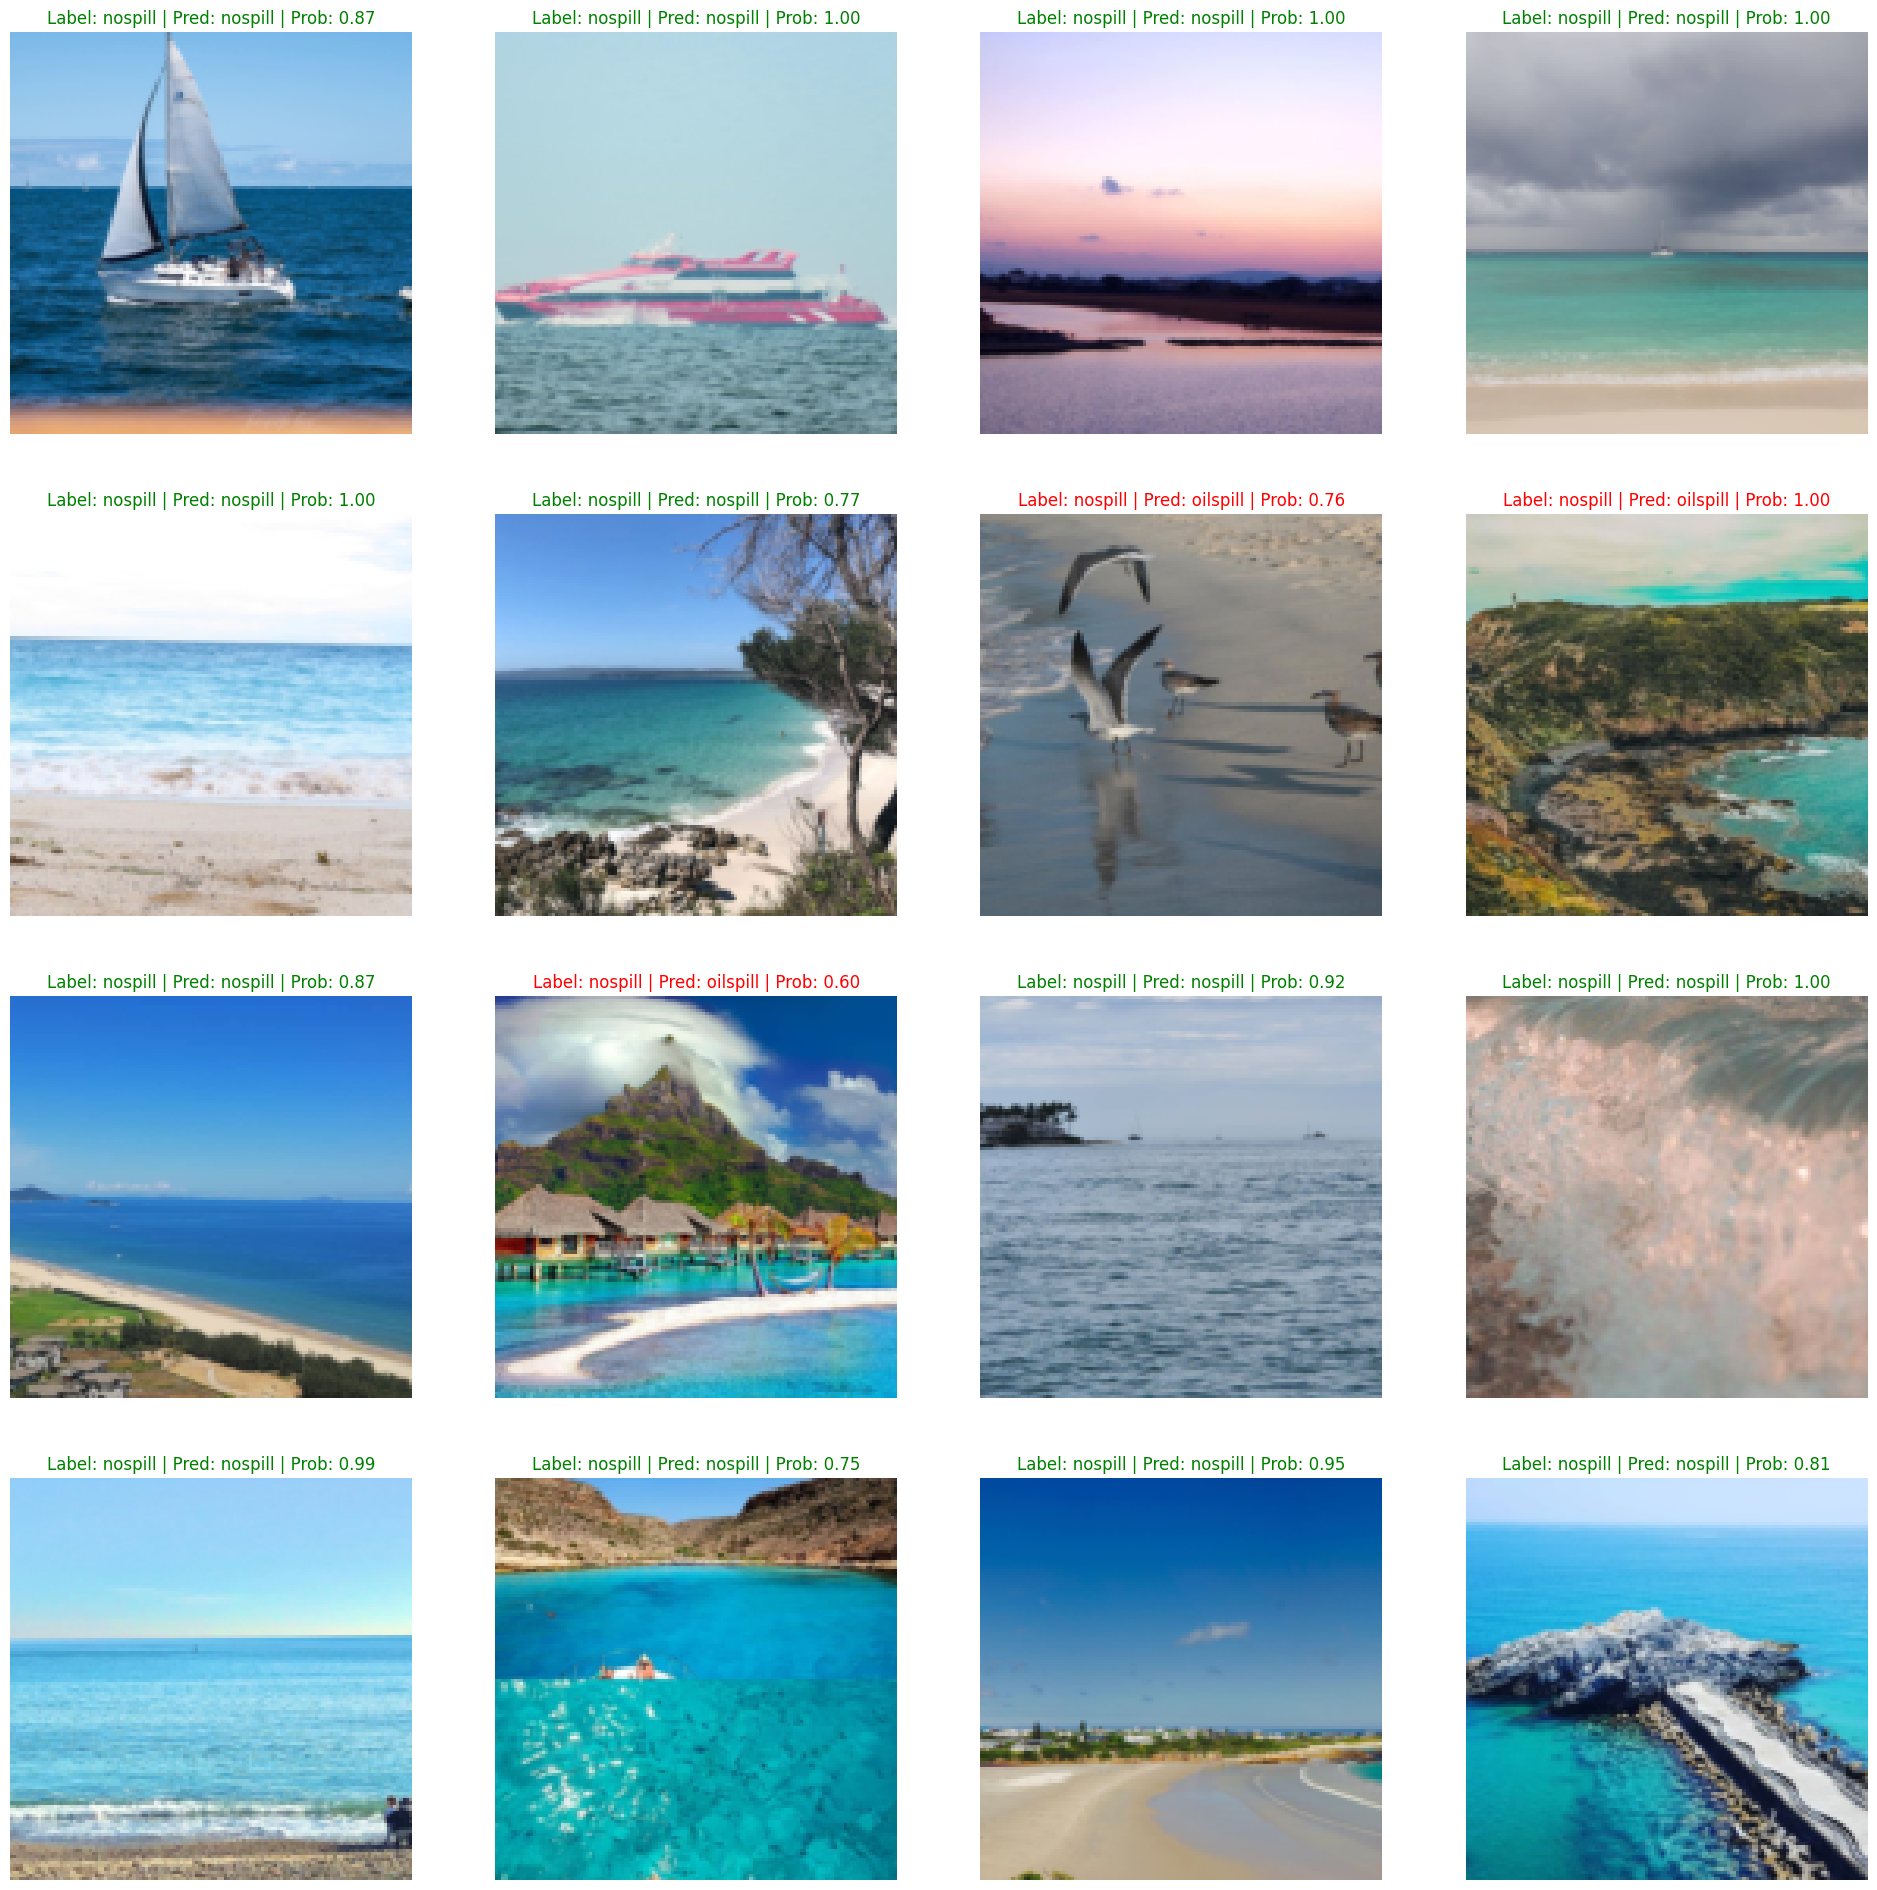

In [33]:
fig, axes = plt.subplots(4,4, figsize = (24,24))

for img, label, pred, ax in zip (feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1,2,0).cpu())
    font = {"color": 'r'} if label != pred.argmax(0) else {"color":'g'}
    label, pred, prob = label2cat [label.item()], label2cat[pred.argmax(0).item()], "{:.2f}".format(max(np.exp(pred)).item())
    ax.set_title(f"Label: {label} | Pred: {pred} | Prob: {prob}", fontdict= font)
    ax.axis("off")

In [56]:
fig.savefig("/content/oily2.jpg")

In [57]:
crop_size = 128
loader = transforms.Compose([
            transforms.Resize(70),
            transforms.CenterCrop(crop_size),
            transforms.ToTensor()])

In [58]:
from PIL import Image
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    #image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

In [59]:
images = image_loader("/content/oily2.jpg")
images.shape

torch.Size([1, 3, 128, 128])

In [60]:
with torch.no_grad():
    model.eval()
    output = model (images)
    print(f"there is %s with probability %s" %(label2cat[output.argmax(1).item()], "{:.2f}".format(max(np.exp(output)[0]))))

there is nospill with probability 0.95


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
